<a href="https://colab.research.google.com/github/Arevik2004/arevik/blob/main/_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Отчет по лабораторной работе на тему:HBase
# Выполнила работу студент группы ПИН-Б-З-22-1
# Элбакян Аревик Ашотовна


Задачи
1. Создайте функцию под названием put_many(), которая создает экземпляр Put, добавляет любое
количество пар "колонка-значение" и фиксирует их в таблице. Сигнатура должна выглядеть
следующим образом:


In [ ]:
def put_many(table_name, row, column_values)
end

2.Определите свою функцию put_many() путем ее вставки в оболочку HBase и вызовите ее
следующим образом:

In [ ]:
hbase> put_many 'wiki', 'Some title', {
hbase*  "text:" => "Some article text",
hbase*  "revision:author" => "jschmoe",
hbase*  "revision:comment" => "no comment" }

# Ход работы
1.Создаем функцию под названием put_many()и добавляе в код

In [ ]:
def put_many(table_name, row, column_values)
 # Получаем таблицу из HBase
table = get_table(table_name)
# Создаем экземпляр Put с ключом строки
put = org.apache.hadoop.hbase.client.Put.new(
org.apache.hadoop.hbase.util.Bytes.toBytes(row.to_s)

In [ ]:
# Добавляем любое количество пар "колонка-значение"
column_values.each do |column, value|
# Разделяем колонку на family и qualifier
family, qualifier = column.split(":")
# Если qualifier не указан, используем пустую строку
 qualifier ||= ""

In [ ]:
# Добавляем колонку в объект Put
put.addColumn(
org.apache.hadoop.hbase.util.Bytes.toBytes(family.to_s),
org.apache.hadoop.hbase.util.Bytes.toBytes(qualifier.to_s),
org.apache.hadoop.hbase.util.Bytes.toBytes(value.to_s)
)
end

In [ ]:
 table.put(put)
  puts "Данные добавлены в строку '#{row}'"
end

2.ВЫЗОВ ФУНКЦИИ

In [ ]:
put_many 'wiki', 'Some title', {
  "text:" => "Some article text",
  "revision:author" => "jschmoe",
  "revision:comment" => "no comment" }

# Результат:


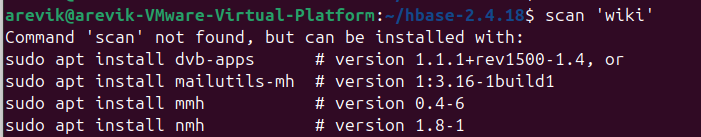

# 3. Создайте новую таблицу под названием foods с одним семейством столбцов для хранения фактов. Что следует использовать в качестве ключа строки? Какие параметры семейства столбцов имеют смысл для этих данных?

In [ ]:
# Задание 1: Создание таблицы
create 'foods', {NAME => 'facts', VERSIONS => 1}

In [ ]:
create 'foods',
  {NAME => 'facts',
   VERSIONS => 1,                    # Только последняя версия фактов
   BLOOMFILTER => 'ROWCOL',          # Оптимизация поиска по колонкам
   COMPRESSION => 'SNAPPY',          # Сжатие для экономии места
   BLOCKSIZE => '65536',             # Стандартный размер блока
   IN_MEMORY => 'false',             # Не хранить в памяти (данные редко меняются)
   TTL => 'FOREVER',                 # Данные хранятся вечно
   BLOCKCACHE => 'true'}             # Кэширование блоков

# 4. Создайте новый скрипт на JRuby для импорта пищевых данных. Используйте метод анализапотокового XML, который мы использовали ранее для скрипта импорта Википедии, иадаптируйте его для пищевых данных. Передайте пищевые данные в ваш скрипт через командную строку, чтобы заполнить таблицу.

In [ ]:
#!/usr/bin/env jruby

require 'java'
require 'rexml/document'
require 'optparse'

# HBase импорты
import 'org.apache.hadoop.hbase.HBaseConfiguration'
import 'org.apache.hadoop.hbase.client.HTable'
import 'org.apache.hadoop.hbase.client.Put'
import 'org.apache.hadoop.hbase.util.Bytes'

class FoodImporter
  def initialize(table_name = 'foods')
    config = HBaseConfiguration.create
    @table = HTable.new(config, table_name)
    @batch_size = 100
    @batch = []
  end

  def import_from_xml(xml_file)
    puts "Импорт данных из #{xml_file}..."

    File.open(xml_file) do |file|
      doc = REXML::Document.new(file)

      doc.elements.each('foods/food') do |food_element|
        process_food(food_element)

In [ ]:
# Пакетная вставка
        if @batch.size >= @batch_size
          flush_batch
        end
      end

In [ ]:
# Вставка оставшихся
      flush_batch if @batch.any?
    end

    puts "Импорт завершен!"
  end

  def process_food(food_element)
    food_id = food_element.attributes['id']
    food_name = food_element.elements['name'].text.downcase.gsub(/\s+/, '_')

In [ ]:
 # Создаем ключ строки
    row_key = "food_#{food_id}_#{food_name}"
    put = Put.new(Bytes.toBytes(row_key))

In [ ]:
# Основные факты
    put_fact(put, 'name', food_element.elements['name'].text)
    put_fact(put, 'category', food_element.elements['category'].text)
    put_fact(put, 'description', food_element.elements['description'].text) if food_element.elements['description']

In [ ]:
 # Пищевая ценность
    nutrition = food_element.elements['nutrition']
    if nutrition
      put_nutrition(put, 'calories', nutrition.elements['calories'].text)
      put_nutrition(put, 'protein', nutrition.elements['protein'].text)
      put_nutrition(put, 'carbs', nutrition.elements['carbs'].text)
      put_nutrition(put, 'fat', nutrition.elements['fat'].text)
      put_nutrition(put, 'fiber', nutrition.elements['fiber'].text) if nutrition.elements['fiber']
    end

In [ ]:
# Дополнительные данные
    food_element.elements.each('additional/*') do |element|
      put_fact(put, element.name, element.text)
    end

    @batch << put
    puts "Добавлен продукт: #{food_name} (ID: #{food_id})"
  end

  def put_fact(put, qualifier, value)
    put.add(
      Bytes.toBytes('facts'),
      Bytes.toBytes(qualifier),
      Bytes.toBytes(value.to_s)
    )
  end

  def put_nutrition(put, qualifier, value)
    put.add(
      Bytes.toBytes('facts'),  # Все в одном family для простоты запросов
      Bytes.toBytes("nutrition_#{qualifier}"),
      Bytes.toBytes(value.to_s)
    )
  end

  def flush_batch
    puts "Вставка #{@batch.size} записей..."
    @table.put(@batch)
    @batch.clear
  end

  def close
    @table.close
  end
end

In [ ]:
# Аргументы командной строки
options = {}
OptionParser.new do |opts|
  opts.banner = "Использование: jruby import_foods.rb [options]"

  opts.on("-f", "--file FILE", "XML файл с данными о продуктах") do |f|
    options[:file] = f
  end

  opts.on("-t", "--table TABLE", "Имя таблицы HBase (по умолчанию: foods)") do |t|
    options[:table] = t
  end

  opts.on("-b", "--batch SIZE", "Размер пакетной вставки (по умолчанию: 100)") do |b|
    options[:batch] = b.to_i
  end
end.parse!

In [ ]:
# Запуск импорта
begin
  importer = FoodImporter.new(options[:table] || 'foods')
  importer.instance_variable_set(:@batch_size, options[:batch]) if options[:batch]

  if options[:file]
    importer.import_from_xml(options[:file])
  else
    puts "Ошибка: Не указан файл для импорта"
    puts "Пример: jruby import_foods.rb -f foods.xml"
  end

  importer.close
rescue => e
  puts "Ошибка импорта: #{e.message}"
  puts e.backtrace.join("\n")
  exit 1
end